In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver
    
import SimPEG.electromagnetics.frequency_domain as fdem
from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})

## Load Data and Plot

In [34]:
# path to the directory containing our data
dir_path = "./3d_simulation_data/"
data_filename = dir_path + "em3dfm_data.txt"

In [35]:
location_index = 0

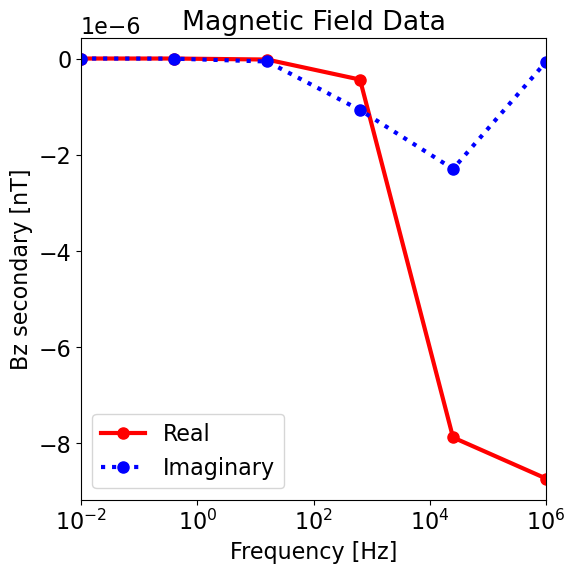

In [36]:
dobs = np.loadtxt(str(data_filename), skiprows=1)
ntx = int((dobs.shape[1]-1)/2)

# Define receiver locations and observed data
frequencies = dobs[:, 0]
dobs_real = dobs[:, 1:ntx+1].T
dobs_imag = dobs[:, ntx+1:].T

# Plot FEM response for all frequencies
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.semilogx(frequencies, (10**9)*dobs_real[location_index, :], "r-o", lw=3)
ax.semilogx(frequencies, (10**9)*dobs_imag[location_index, :], "b:o", lw=3)
ax.set_xlim((np.min(frequencies), np.max(frequencies)))
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Bz secondary [nT]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.show()

## Defining the Survey

In [37]:
frequencies = np.logspace(-2, 6, 6)
sep = 10
x_position = np.arange(0, 10000, 1000)
# Defining transmitter locations
xtx, ytx, ztx = np.meshgrid(x_position[location_index], [0], [30])
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid(x_position[location_index] + sep, [0], [30])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

# Each unique location and frequency defines a new transmitter

# Each unique location and frequency defines a new transmitter
for ii in range(len(frequencies)):
    for jj in range(ntx):
        # Define receivers of different type at each location
        bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
            receiver_locations[jj, :], "z", "real"
        )

        bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
            receiver_locations[jj, :], "z", "imag"
        )
        receivers_list = [bzr_receiver, bzi_receiver]
        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list,
                frequencies[ii],
                source_locations[jj],
                orientation="z",
                # momemt = 100
            )
        )

# # create the survey and problem objects for running the forward simulation
survey = fdem.Survey(source_list)

## Assign Uncertainties

In [38]:
# Recover the vector data structure
bz_real = dobs_real[location_index]
bz_imag = dobs_imag[location_index]

dobs_recovered = np.empty(bz_real.size + bz_imag.size, dtype=bz_real.dtype)
dobs_recovered[0::2] = bz_real
dobs_recovered[1::2] = bz_imag

In [39]:
uncertainties = 0.01 * np.abs(dobs_recovered) * np.ones(np.shape(dobs_recovered))

In [40]:
data_object = data.Data(survey, dobs=dobs_recovered, noise_floor=uncertainties)

## Weighted Least-Squares Inversion

In [41]:
# estimated host conductivity (S/m)
estimated_resistivity = 100

# minimum skin depth
d_min = 500.0 * np.sqrt(estimated_resistivity/ frequencies.max())
print("MINIMUM SKIN DEPTH: {} m".format(d_min))

# maximum skin depth
d_max = 500.0 * np.sqrt(estimated_resistivity/ frequencies.min())
print("MAXIMUM SKIN DEPTH: {} m".format(d_max))

MINIMUM SKIN DEPTH: 5.0 m
MAXIMUM SKIN DEPTH: 50000.0 m


In [42]:
depth_min = 10  # top layer thickness
depth_max = 6000.0  # depth to lowest layer
geometric_factor = 1.1  # rate of thickness increase

In [43]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers
print("n_layers: ", n_layers)

n_layers:  45


## Model and Mapping to Layer Conductivities

In [44]:
log_resistivity_map = maps.ExpMap(nP=n_layers)

## Define a Refernce Model and the Mapping

In [45]:
# Starting model is log-conductivity values (S/m)
starting_resistivity_model = np.log((estimated_resistivity) * np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_resistivity_model = starting_resistivity_model.copy()

In [64]:
import discretize
from discretize.utils import ndgrid
# domain OcTree mesh

dh = 250.0  # base cell width
dom_width_x = 12000.0  # domain width x
dom_width_y = 12000.0  # domain width y
dom_width_z = 6000.0  # domain width z

# Number of base mesh cells in each direction. Must be a power of 2
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]  # Shifting start point by -6000 to center at 500
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]
mesh = discretize.TreeMesh([hx, hy, hz])

#define core extent
core_points = ndgrid(
    np.r_[0, 10000], np.r_[0, 10000], np.r_[-4000, 0]
)

mesh.x0= [-3000, -3000, -8000]

#Refine mesh around core region
mesh.refine_bounding_box(core_points, -1, padding_cells_by_level=[2,2,4], finalize=False)

mesh.finalize()

In [66]:
simulation_L2 = fdem.simulation.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, rhoMap=log_resistivity_map, solver=Solver
)

## Define Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem

In [67]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

In [68]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 45 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     45     -7,128.81         -0.00     10.00    602.40    1.10




In [69]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    length_scale_x=10.0,
    reference_model=reference_resistivity_model,
    reference_model_in_smooth=False,
)

In [70]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

## Define Inversion Directives

In [71]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [72]:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [update_jacobi, 
                      starting_beta, 
                      beta_schedule, 
                      target_misfit]

In [75]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(np.log(estimated_resistivity) * np.ones(mesh.nC))

The callback on the InexactGaussNewton Optimization was replaced.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DMagneticFluxDensity problem***
                        


ValueError: operands could not be broadcast together with shapes (40772,) (45,) 

In [54]:
dpred_L2 = simulation_L2.dpred(recovered_model_L2)

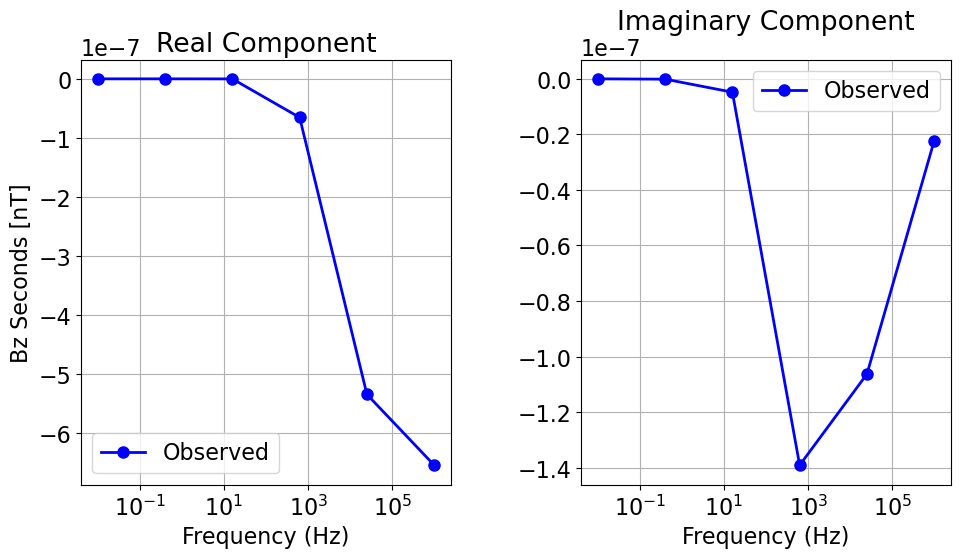

In [55]:
fig = plt.figure(figsize=(10, 5))
ax = [fig.add_axes([0.1 + ii * 0.5, 0.1, 0.37, 0.85]) for ii in range(2)]
for ii in range(2):
    ax[ii].semilogx(frequencies, (dpred_L2[ii::2]), "b-o", lw=2)
    ax[ii].grid(which="both")
    ax[ii].set_xlabel("Frequency (Hz)")
    ax[ii].set_ylabel("Bz Seconds [nT]")
    ax[ii].legend(["Observed", "L2 Inversion"])
    if ii == 1:
        ax[ii].set_ylabel("")

ax[0].set_title("Real Component")
ax[1].set_title("Imaginary Component")
plt.show()

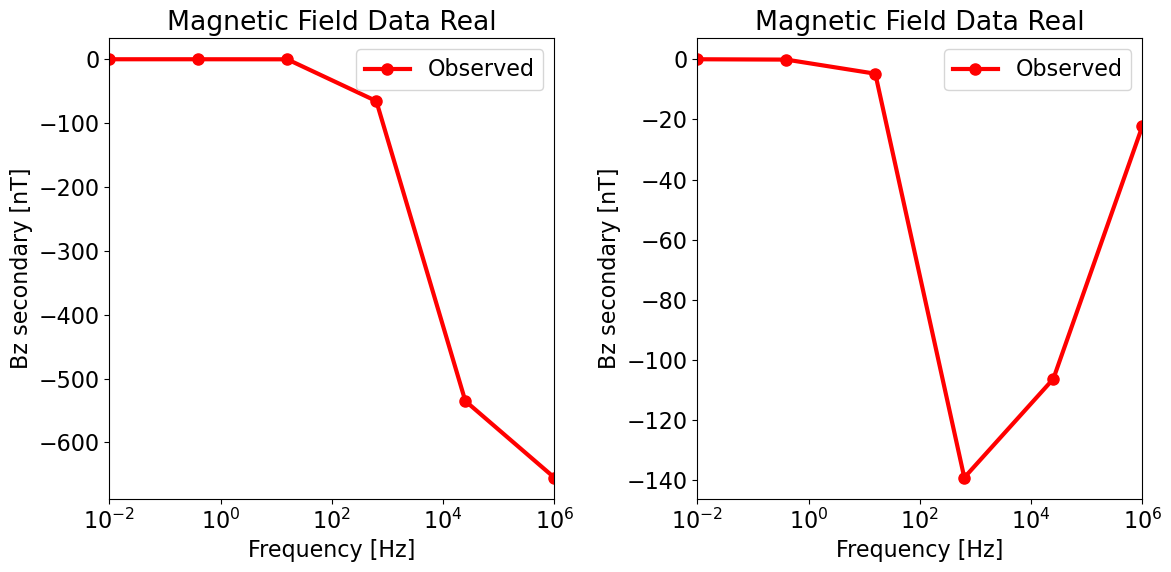

In [56]:
# Data are organized by transmitter location, then component, then frequency. We had nFreq
# transmitters and each transmitter had 2 receivers (real and imaginary component). So
# first we will pick out the real and imaginary data
bz_real_recovered = dpred_L2[0 : len(dpred_L2) : 2]
bz_imag_recovered = dpred_L2[1 : len(dpred_L2) : 2]

# Then we will will reshape the data.
# bz_real_recovered = np.reshape(bz_real_recovered, (ntx, len(frequencies)))
# bz_imag_recovered = np.reshape(bz_imag_recovered, (ntx, len(frequencies)))

# Plot FEM response for all frequencies
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
location_index = 2
# ax[0].semilogx(frequencies, (10**9)*dobs_real[location_index, :], "k-x", lw=3)
ax[0].semilogx(frequencies, (10**9)*bz_real_recovered, "r-o", lw=3)
# ax[1].semilogx(frequencies, (10**9)*dobs_imag[location_index, :], "k-x", lw=3)
ax[1].semilogx(frequencies, (10**9)*bz_imag_recovered, "r-o", lw=3)

for axis in ax:
    axis.set_xlim((np.min(frequencies), np.max(frequencies)))
    axis.set_xlabel("Frequency [Hz]")
    axis.set_ylabel("Bz secondary [nT]")
    axis.set_title("Magnetic Field Data Real")
    axis.legend(["Observed", "L2 Inversion"])
plt.tight_layout()

In [57]:
true_layers = np.array([500.0])
true_resistivities = np.r_[1000, 100]

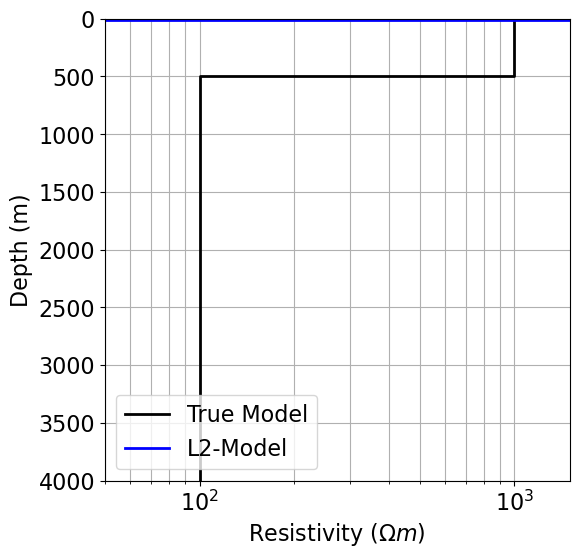

In [63]:
fig, ax = plt.subplots(1,1, figsize=(6, 6))

plot_1d_layer_model(true_layers, true_resistivities, scale="log", ax=ax, color="k")
plot_1d_layer_model(layer_thicknesses, log_resistivity_map * recovered_model_L2, ax=ax, color="b")
ax.grid(which="both")
ax.set_xlabel(r"Resistivity ($\Omega m$)")
x_min, x_max = true_resistivities.min(), true_resistivities.max()
ax.set_ylim([4000, 0])
ax.set_xlim(0.5 * x_min, 1.5 * x_max)
ax.legend(["True Model", "L2-Model"])
plt.show()